In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
sys.path.append(os.path.abspath('..'))


# LOAD RESOURCES
model_path = 'data/processed/epm_model_optimized_turbo.pkl'
encoder_path = 'data/processed/aircraft_encoder.pkl'
data_path = 'data/processed/dataset_train_ready.csv'

model = joblib.load(model_path)
encoder = joblib.load(encoder_path)
df = pd.read_csv(data_path)

In [6]:
# OPTIMIZATION ENGINE

def get_flight_optimum(row):
    """
    Finds the optimal Speed and Altitude for a given flight row
    using a grid search on the Surrogate Model.
    """
    # 1. Create a search grid (Speed vs Altitude)
    v_range = np.linspace(140, 280, 30)   # Speed range: 140 to 280 m/s
    h_range = np.linspace(8000, 13000, 30) # Altitude range: 8km to 13km
    
    V, H = np.meshgrid(v_range, h_range)
    
    # Flatten grid for pandas
    sim_df = pd.DataFrame({'velocity': V.ravel(), 'altitude': H.ravel()})
    
    # 2. Fill constant conditions from the specific flight
    cols_const = ['mass_kg', 'aircraft_type_encoded', 'wing_area', 'cd0', 'cd2', 'u_wind', 'v_wind']
    for c in cols_const:
        sim_df[c] = row[c]
    
    # 3. Physics Correction: Temperature Lapse Rate
    # Adjust temperature based on the altitude difference
    delta_h = sim_df['altitude'] - row['altitude']
    sim_df['temperature'] = row['temperature'] - 0.0065 * delta_h
    
    # 4. Safety Check: Stall Speed
    # Calculate approximate air density
    rho = 1.225 * (1 - 2.25577e-5 * sim_df['altitude'])**4.25
    
    # Calculate Stall Speed (V_stall)
    # Formula: sqrt( 2 * mass * g / (rho * S * CL_max) )
    # We assume CL_max approx 1.4 for cruise config
    v_stall = np.sqrt((2 * row['mass_kg'] * 9.81) / (rho * row['wing_area'] * 1.4))
    
    # Filter: Keep only speeds above 1.3 * V_stall
    sim_safe = sim_df[sim_df['velocity'] > v_stall * 1.3]
    
    # Fallback if no safe solution found
    if sim_safe.empty:
        return row['velocity'], row['altitude']
    
    # 5. Predict EPM using the Surrogate Model
    cols_order = ['velocity', 'altitude', 'mass_kg', 'aircraft_type_encoded', 
                  'wing_area', 'cd0', 'cd2', 'temperature', 'u_wind', 'v_wind']
    
    sim_safe = sim_safe.copy()
    sim_safe['predicted_epm'] = model.predict(sim_safe[cols_order])
    
    # Find minimum
    best_row = sim_safe.loc[sim_safe['predicted_epm'].idxmin()]
    return best_row['velocity'], best_row['altitude']

# FIND REPRESENTATIVE FLIGHTS 

# Define the 4 target scenarios
scenarios = {
    "Accelerate": lambda r, v, h: v > r['velocity'] + 20, # Recommend +20 m/s
    "Decelerate": lambda r, v, h: v < r['velocity'] - 20, # Recommend -20 m/s
    "Climb":      lambda r, v, h: h > r['altitude'] + 1000, # Recommend +1000 m
    "Descend":    lambda r, v, h: h < r['altitude'] - 1000  # Recommend -1000 m
}

selected_flights = []
found_types = set()

print("Scanning dataset for scenarios...")

# Shuffle dataset to get random samples
shuffled_df = df.sample(frac=1, random_state=42)

for _, row in shuffled_df.iterrows():
    # Stop if we found all 4 scenarios
    if len(found_types) == 4:
        break
        
    v_opt, h_opt = get_flight_optimum(row)
    
    for label, check in scenarios.items():
        if label not in found_types and check(row, v_opt, h_opt):
            # Save this flight
            row_copy = row.copy()
            row_copy['scenario_label'] = label
            selected_flights.append(row_copy)
            found_types.add(label)
            
            ac = encoder.inverse_transform([int(row['aircraft_type_encoded'])])[0]
            print(f"Found [{label}]: {ac} (Alt: {row['altitude']:.0f}m, V: {row['velocity']:.0f}m/s)")

print("Scan complete.")

Scanning dataset for scenarios...
Found [Decelerate]: A320 (Alt: 11224m, V: 217m/s)
Found [Climb]: A320 (Alt: 9334m, V: 205m/s)
Found [Descend]: B748 (Alt: 9921m, V: 244m/s)
Found [Accelerate]: B788 (Alt: 12047m, V: 220m/s)
Scan complete.


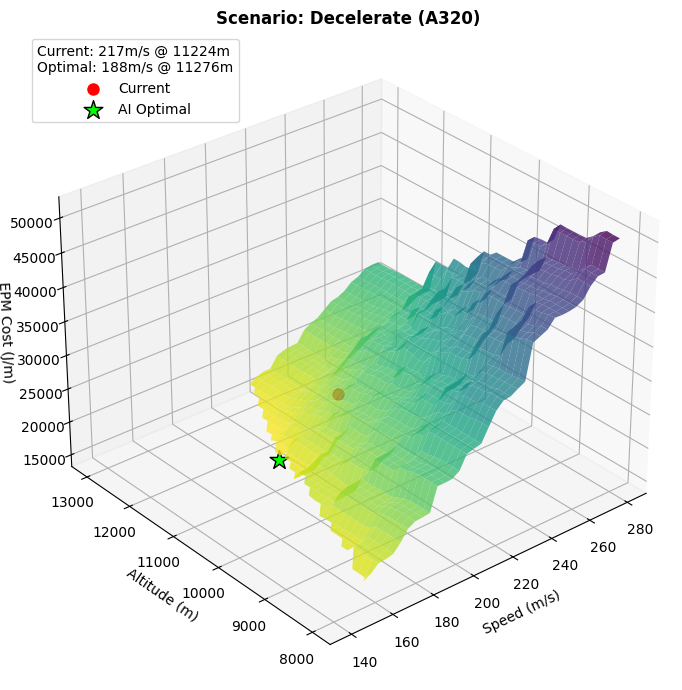

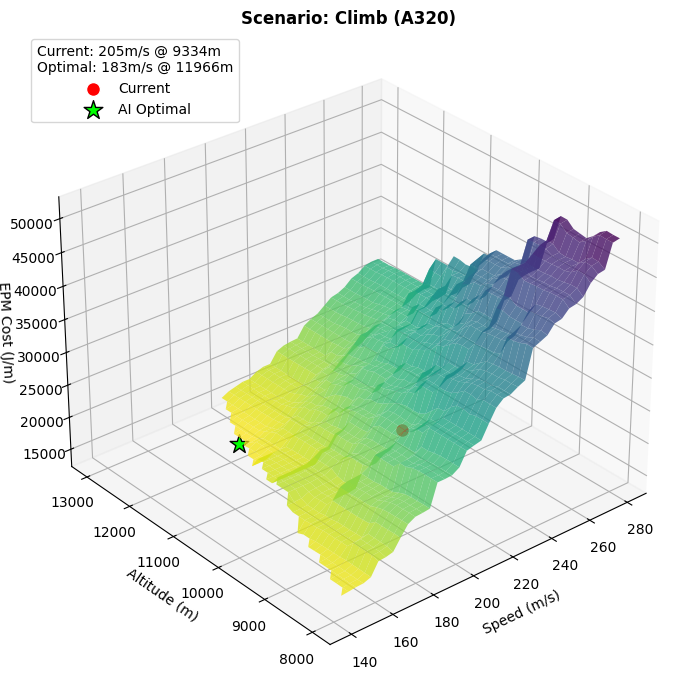

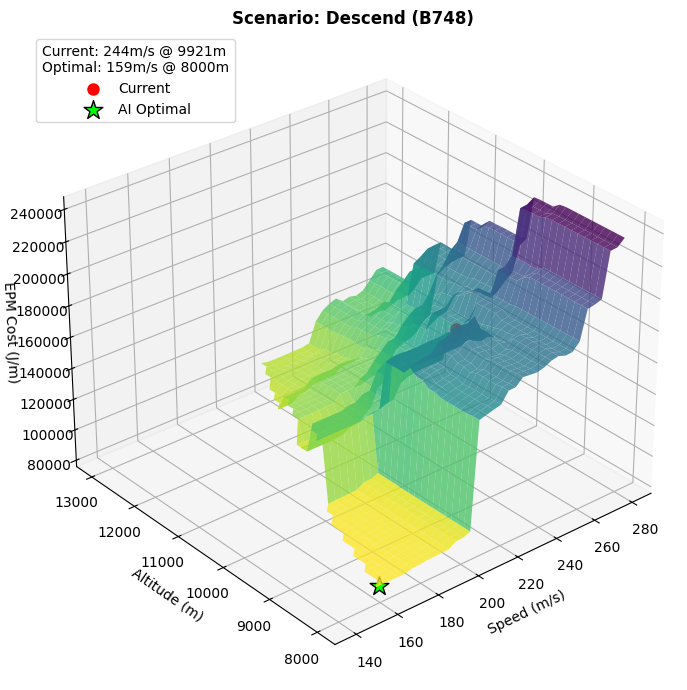

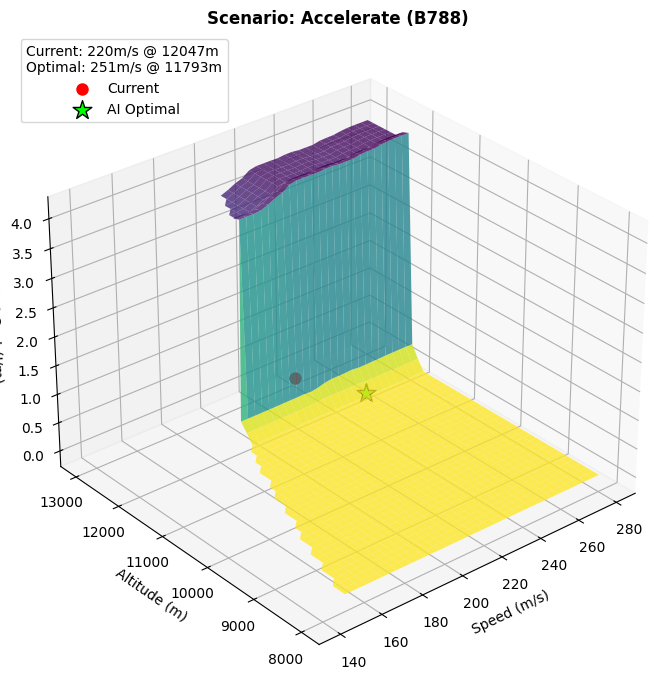

In [7]:
# 3D VISUALIZATION LOOP 

for row in selected_flights:
    # 1. Prepare Data
    ac_name = encoder.inverse_transform([int(row['aircraft_type_encoded'])])[0]
    label = row['scenario_label']
    
    # Recalculate Optimum
    v_opt, h_opt = get_flight_optimum(row)
    
    # Create Grid for Plotting
    v_range = np.linspace(140, 280, 40)
    h_range = np.linspace(8000, 13000, 40)
    V, H = np.meshgrid(v_range, h_range)
    
    # Create Simulation DataFrame
    sim_df = pd.DataFrame({'velocity': V.ravel(), 'altitude': H.ravel()})
    
    cols_const = ['mass_kg', 'aircraft_type_encoded', 'wing_area', 'cd0', 'cd2', 'u_wind', 'v_wind']
    for c in cols_const:
        sim_df[c] = row[c]
        
    # Temperature Correction
    delta_h = sim_df['altitude'] - row['altitude']
    sim_df['temperature'] = row['temperature'] - 0.0065 * delta_h
    
    # Safety Mask (Stall Speed)
    rho = 1.225 * (1 - 2.25577e-5 * sim_df['altitude'])**4.25
    v_stall = np.sqrt((2 * row['mass_kg'] * 9.81) / (rho * row['wing_area'] * 1.4))
    mask_unsafe = sim_df['velocity'] < (v_stall * 1.3)
    
    # Prediction
    cols_order = ['velocity', 'altitude', 'mass_kg', 'aircraft_type_encoded', 
                  'wing_area', 'cd0', 'cd2', 'temperature', 'u_wind', 'v_wind']
    epm_pred = model.predict(sim_df[cols_order])
    
    # Apply Mask (Set unsafe areas to NaN so they don't plot)
    epm_pred[mask_unsafe] = np.nan
    Z_epm = epm_pred.reshape(V.shape)
    
    # Get Precise Optimal EPM value for plotting the marker
    row_opt = row.copy()
    row_opt['velocity'] = v_opt
    row_opt['altitude'] = h_opt
    # Adjust temp for single point
    row_opt['temperature'] = row['temperature'] - 0.0065 * (h_opt - row['altitude'])
    opt_epm_val = model.predict(pd.DataFrame([row_opt])[cols_order])[0]

    # 2. Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface Plot
    # X = Speed, Y = Altitude, Z = EPM (Cost)
    surf = ax.plot_surface(V, H, Z_epm, cmap='viridis_r', alpha=0.8, edgecolor='none')
    
    # Marker: Current Situation (Red Circle)
    ax.scatter([row['velocity']], [row['altitude']], [row['epm']], 
               color='red', s=100, label='Current', zorder=10, edgecolors='white')
    
    # Marker: AI Recommendation (Green Star)
    ax.scatter([v_opt], [h_opt], [opt_epm_val], 
               color='#00ff00', s=200, marker='*', label='AI Optimal', zorder=10, edgecolors='black')
    
    # Labels
    ax.set_title(f"Scenario: {label} ({ac_name})", fontsize=12, fontweight='bold')
    ax.set_xlabel('Speed (m/s)')
    ax.set_ylabel('Altitude (m)')
    ax.set_zlabel('EPM Cost (J/m)')
    
    # Set view angle to see the "valley" clearly
    ax.view_init(elev=30, azim=-130)
    
    # Legend
    txt_current = f"Current: {row['velocity']:.0f}m/s @ {row['altitude']:.0f}m"
    txt_opt = f"Optimal: {v_opt:.0f}m/s @ {h_opt:.0f}m"
    ax.legend(title=f"{txt_current}\n{txt_opt}", loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [8]:
# INTERACTIVE DASHBOARD

available_aircrafts = list(encoder.classes_)

# 1. Calculation Logic
def compute_interactive_scenario(aircraft_str, mass_t, altitude, temp_offset, wind_speed, wind_dir):
    
    mass_kg = mass_t * 1000
    aircraft_encoded = encoder.transform([aircraft_str])[0]
    
    # Wind Components
    rad = np.radians(wind_dir)
    u_wind = -wind_speed * np.sin(rad)
    v_wind = -wind_speed * np.cos(rad)
    
    # Temperature (ISA + Offset)
    temp_isa = 288.15 - 0.0065 * altitude
    temperature = temp_isa + temp_offset
    
    # Generic specs for demo
    wing_area = 122.6 if "A32" in aircraft_str else 124.6
    cd0, cd2 = 0.02, 0.04
    
    # Simulation Range
    velocities = np.linspace(140, 280, 100)
    
    data = pd.DataFrame({
        'velocity': velocities,
        'altitude': altitude,
        'mass_kg': mass_kg,
        'aircraft_type_encoded': aircraft_encoded,
        'wing_area': wing_area,
        'cd0': cd0, 'cd2': cd2,
        'temperature': temperature,
        'u_wind': u_wind, 'v_wind': v_wind
    })
    
    # Predict
    cols = ['velocity', 'altitude', 'mass_kg', 'aircraft_type_encoded', 
            'wing_area', 'cd0', 'cd2', 'temperature', 'u_wind', 'v_wind']
    epm_pred = model.predict(data[cols])
    
    # Safety Calculation
    pressure = 101325 * (1 - 2.25577e-5 * altitude)**5.25588
    rho = pressure / (287.05 * temperature)
    v_stall = np.sqrt((2 * mass_kg * 9.81) / (rho * wing_area * 1.4))
    v_safe_limit = v_stall * 1.3
    
    return velocities, epm_pred, v_safe_limit

# 2. Widgets
style = {'description_width': 'initial'}
layout = widgets.Layout(width='320px')

w_ac = widgets.Dropdown(options=available_aircrafts, value=available_aircrafts[0], description='Aircraft Type:', style=style, layout=layout)
w_mass = widgets.FloatSlider(value=65, min=40, max=90, step=1, description='Mass (tonnes):', style=style, layout=layout)
w_alt = widgets.FloatSlider(value=10000, min=6000, max=13000, step=500, description='Altitude (m):', style=style, layout=layout)
w_temp = widgets.FloatSlider(value=0, min=-30, max=30, step=1, description='Temp Deviation (K):', style=style, layout=layout)
w_wind_spd = widgets.FloatSlider(value=20, min=0, max=100, step=5, description='Wind Speed (m/s):', style=style, layout=layout)
w_wind_dir = widgets.IntSlider(value=0, min=0, max=360, step=10, description='Wind Direction (deg):', style=style, layout=layout)

out = widgets.Output()

def update_dashboard(change=None):
    with out:
        clear_output(wait=True)
        
        # Compute
        velocities, epm_values, v_limit = compute_interactive_scenario(
            w_ac.value, w_mass.value, w_alt.value, 
            w_temp.value, w_wind_spd.value, w_wind_dir.value
        )
        
        # Filter Safe Zone
        safe_mask = velocities >= v_limit
        v_safe = velocities[safe_mask]
        epm_safe = epm_values[safe_mask]
        
        opt_v, opt_epm = (v_safe[np.argmin(epm_safe)], np.min(epm_safe)) if len(epm_safe) > 0 else (0,0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Danger Zone
        ax.axvspan(140, v_limit, color='red', alpha=0.15, label='Stall Danger Zone')
        ax.axvline(v_limit, color='red', linestyle='--', label='Safety Limit (1.3 Vs)')
        
        # Curves
        ax.plot(velocities, epm_values, linewidth=3, label='EPM Curve', color='#1f77b4')
        
        if opt_v > 0:
            ax.scatter(opt_v, opt_epm, color='#2ca02c', s=150, zorder=5, label='Optimal Point')
            # Info Box
            textstr = f'OPTIMAL SPEED: {opt_v:.1f} m/s\nMIN COST: {opt_epm:.0f} J/m'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                    verticalalignment='top', bbox=props)

        ax.set_title(f"Real-Time Flight Optimizer - {w_ac.value}", fontsize=14)
        ax.set_xlabel("True Airspeed (m/s)")
        ax.set_ylabel("Energy Consumption (J/m)")
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right')
        ax.set_xlim(140, 280)
        plt.show()

# Link widgets
for w in [w_ac, w_mass, w_alt, w_temp, w_wind_spd, w_wind_dir]:
    w.observe(update_dashboard, names='value')

# Layout
ui = widgets.VBox([
    widgets.HBox([w_ac, w_mass]),
    widgets.HBox([w_alt, w_temp]),
    widgets.HBox([w_wind_spd, w_wind_dir])
])

update_dashboard()
display(ui, out)

Output()